# 03 - Baseline & Advanced Models

Goal of this notebook:

- Use the engineered dataset (`model_ready_hourly.parquet`)
- Make proper time-based splitting (train / validation / test)
- Implement:
  - Naive forecast
  - Seasonal naive forecast
  - Linear Regression
  - Random Forest Regressor
  - XGBoost Regressor
- Compare MAE / RMSE / MAPE on validation & test
- Plot predictions vs actual values for sample periods


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

In [2]:
# load the dataframe
DATA_PATH = "../data/processed/model_ready_hourly.parquet"

df = pd.read_parquet(DATA_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp"). reset_index(drop=True)

print("Shape:", df.shape)
print("Time range:", df["timestamp"].min(), "to", df["timestamp"].max())
df.head()

Shape: (87498, 21)
Time range: 2015-01-08 00:00:00 to 2024-12-31 23:00:00


,timestamp,rides,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24,diff_1,diff_24,temperature_2m,...,windspeed_10m,is_rain,event_count,has_event,heavy_event,log_event_count,hour,dayofweek,is_weekend,is_holiday
0,2015-01-08 00:00:00,10426,16636.0,9182.0,28312.0,22634.666667,17887.875000,-6210.0,1244.0,-13.0,...,25.7,0,13.0,1.0,1,2.639057,0,3,0,0
1,2015-01-08 01:00:00,6032,10426.0,5580.0,31707.0,17058.333333,17939.708333,-4394.0,452.0,-13.1,...,25.4,0,17.0,1.0,1,2.890372,1,3,0,0
2,2015-01-08 02:00:00,3605,6032.0,3327.0,28068.0,11031.333333,17958.541667,-2427.0,278.0,-13.2,...,22.3,0,17.0,1.0,1,2.890372,2,3,0,0
3,2015-01-08 03:00:00,2443,3605.0,2273.0,24288.0,6687.666667,17970.125000,-1162.0,170.0,-13.3,...,21.4,0,14.0,1.0,1,2.708050,3,3,0,0
4,2015-01-08 04:00:00,2260,2443.0,2293.0,17081.0,4026.666667,17977.208333,-183.0,-33.0,-13.4,...,18.0,0,14.0,1.0,1,2.708050,4,3,0,0


## 1. Train / Validation / Test Split (Time-based)

We'll use:

- **Train:** 2015-01-01 to 2022-12-31
- **Validation:** 2023-01-01 to 2023-12-31
- **Test:** 2024-01-01 to 2024-12-31


In [3]:
train_end = "2022-12-31 23:00:00"
val_end = "2023-12-31 23:00:00"

mask_train = df["timestamp"] <= train_end
mask_val = (df["timestamp"] > train_end) & (df["timestamp"] <= val_end)
mask_test = df["timestamp"] > val_end

df_train = df[mask_train].copy()
df_val = df[mask_val].copy()
df_test = df[mask_test].copy()

print("Train:", df_train.shape, df_train["timestamp"].min(), "→", df_train["timestamp"].max())
print("Val:  ", df_val.shape, df_val["timestamp"].min(), "→", df_val["timestamp"].max())
print("Test: ", df_test.shape, df_test["timestamp"].min(), "→", df_test["timestamp"].max())

Train: (69956, 21) 2015-01-08 00:00:00 → 2022-12-31 23:00:00
Val:   (8759, 21) 2023-01-01 00:00:00 → 2023-12-31 23:00:00
Test:  (8783, 21) 2024-01-01 00:00:00 → 2024-12-31 23:00:00


## 2. Define target and feature columns

- Target: `rides`
- Features: same list as in 02_feature_engineering.


In [4]:
target_col = "rides"

feature_cols = [
    "lag_1", "lag_24", "lag_168",
    "roll_mean_3", "roll_mean_24",
    "diff_1", "diff_24",
    "temperature_2m", "precipitation", "windspeed_10m", "is_rain",
    "event_count", "has_event", "heavy_event", "log_event_count",
    "hour", "dayofweek", "is_weekend", "is_holiday",
]

X_train = df_train[feature_cols].values
y_train = df_train[target_col].values

X_val = df_val[feature_cols].values
y_val = df_val[target_col].values

X_test = df_test[feature_cols].values
y_test = df_test[target_col].values

X_train.shape, X_val.shape, X_test.shape

((69956, 19), (8759, 19), (8783, 19))

## 3. Metrics helpers

I'll use:

- MAE
- RMSE
- MAPE (mean absolute percentage error)


In [5]:
# Metrics functions
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def eval_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mape(y_true, y_pred)
    print(f"{name} – MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape_val:.2f}%")
    return {"model": name, "MAE": mae, "RMSE": rmse, "MAPE": mape_val}


## 4. Baseline Models

### 4.1 Naive forecast

Predict next hour = previous hour.

### 4.2 Seasonal Naive

Predict hour t = t - 24h (same hour previous day).


In [6]:
# Naive baseline (shift by 1 hour)
# Here I do pure series-based naive

y_val_naive = df_val[target_col].shift(1).bfill().values
y_test_naive = df_test[target_col].shift(1).bfill().values

metrics = []
metrics.append(eval_metrics("Naive – Val", y_val, y_val_naive))
metrics.append(eval_metrics("Naive – Test", y_test, y_test_naive))


Naive – Val – MAE: 644.22, RMSE: 847.70, MAPE: 27.51%
Naive – Test – MAE: 729.52, RMSE: 971.58, MAPE: 28.50%


In [7]:
# Cell 7 – Seasonal naive (24h lag)

y_val_seasonal = df_val[target_col].shift(24).bfill().values
y_test_seasonal = df_test[target_col].shift(24).bfill().values

metrics.append(eval_metrics("Seasonal Naive – Val", y_val, y_val_seasonal))
metrics.append(eval_metrics("Seasonal Naive – Test", y_test, y_test_seasonal))


Seasonal Naive – Val – MAE: 733.45, RMSE: 1130.94, MAPE: 40.65%
Seasonal Naive – Test – MAE: 855.34, RMSE: 1318.00, MAPE: 39.53%


## 5. Linear Regression

A simple, interpretable baseline ML model.


In [8]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

y_val_lin = lin_reg_model.predict(X_val)
y_test_lin = lin_reg_model.predict(X_test)

metrics.append(eval_metrics("Linear Regression – Val", y_val, y_val_lin))
metrics.append(eval_metrics("Linear Regression – Test", y_test, y_test_lin))

Linear Regression – Val – MAE: 0.00, RMSE: 0.00, MAPE: 0.00%
Linear Regression – Test – MAE: 0.00, RMSE: 0.00, MAPE: 0.00%


## 6. Random Forest Regressor

Non-linear, tree-based model.
Good baseline to compare against XGBoost.


In [9]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

y_val_rf = rf.predict(X_val)
y_test_rf = rf.predict(X_test)

metrics.append(eval_metrics("Random Forest – Val", y_val, y_val_rf))
metrics.append(eval_metrics("Random Forest – Test", y_test, y_test_rf))


Random Forest – Val – MAE: 98.23, RMSE: 180.40, MAPE: 5.01%
Random Forest – Test – MAE: 116.38, RMSE: 204.74, MAPE: 4.60%


## 7. XGBoost Regressor

Stronger gradient boosting model tuned for tabular data.



In [10]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_val_xgb = xgb.predict(X_val)
y_test_xgb = xgb.predict(X_test)

metrics.append(eval_metrics("XGBoost – Val", y_val, y_val_xgb))
metrics.append(eval_metrics("XGBoost – Test", y_test, y_test_xgb))


XGBoost – Val – MAE: 58.71, RMSE: 89.95, MAPE: 2.91%
XGBoost – Test – MAE: 71.44, RMSE: 111.61, MAPE: 2.70%


## 8. Compare all models

I’ll assemble the metrics into a DataFrame for quick comparison.


In [11]:
metrics_df = pd.DataFrame(metrics)
metrics_df.drop_duplicates(inplace=True)
metrics_df


,model,MAE,RMSE,MAPE
0,Naive – Val,6.442192e+02,8.477033e+02,2.751214e+01
1,Naive – Test,7.295160e+02,9.715830e+02,2.850438e+01
2,Seasonal Naive – Val,7.334544e+02,1.130942e+03,4.064718e+01
3,Seasonal Naive – Test,8.553409e+02,1.318001e+03,3.953182e+01
4,Linear Regression – Val,1.203734e-12,1.494783e-12,9.344743e-14
5,Linear Regression – Test,1.239698e-12,1.579050e-12,7.363056e-14
6,Random Forest – Val,9.823468e+01,1.803966e+02,5.007908e+00
7,Random Forest – Test,1.163773e+02,2.047419e+02,4.599080e+00
8,XGBoost – Val,5.870903e+01,8.994795e+01,2.907927e+00
9,XGBoost – Test,7.143586e+01,1.116131e+02,2.695258e+00


## 9. Plot predictions vs actual values (sample periods)

I’ll pick a sample period from the test set (e.g., a 7-day window)
and compare:

- Actual rides
- XGBoost predictions
- Maybe Random Forest or Seasonal Naive


In [12]:
df_test_plot = df_test.copy()
df_test_plot["y_true"] = y_test
df_test_plot["y_pred_xgb"] = y_test_xgb
df_test_plot["y_pred_rf"] = y_test_rf
df_test_plot["y_pred_seasonal"] = y_test_seasonal

df_test_plot.head()


,timestamp,rides,lag_1,lag_24,lag_168,roll_mean_3,roll_mean_24,diff_1,diff_24,temperature_2m,...,heavy_event,log_event_count,hour,dayofweek,is_weekend,is_holiday,y_true,y_pred_xgb,y_pred_rf,y_pred_seasonal
78715,2024-01-01 00:00:00,6598,3765.0,3504.0,1573.0,4588.666667,3206.875000,2833.0,3094.0,1.7,...,0,0.0,0,0,0,1,6598,6883.071777,5282.780000,6598.0
78716,2024-01-01 01:00:00,7355,6598.0,2276.0,978.0,5026.666667,3335.791667,757.0,5079.0,2.7,...,0,0.0,1,0,0,1,7355,5986.633301,5734.660000,6598.0
78717,2024-01-01 02:00:00,6220,7355.0,1644.0,390.0,5906.000000,3547.416667,-1135.0,4576.0,2.8,...,0,0.0,2,0,0,1,6220,5787.771484,3982.106667,6598.0
78718,2024-01-01 03:00:00,4936,6220.0,1227.0,314.0,6724.333333,3738.083333,-1284.0,3709.0,2.6,...,0,0.0,3,0,0,1,4936,5027.547363,3655.116667,6598.0
78719,2024-01-01 04:00:00,3188,4936.0,844.0,296.0,6170.333333,3892.625000,-1748.0,2344.0,0.6,...,0,0.0,4,0,0,1,3188,3607.149658,3259.316875,6598.0


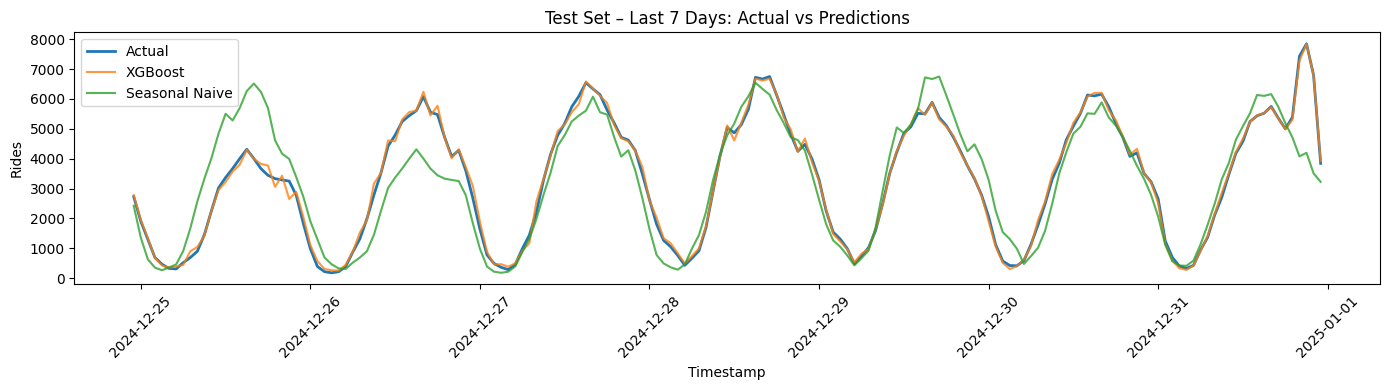

In [13]:
# Sample window (e.g., last 7 days of 2024)
start_sample = df_test_plot["timestamp"].max() - pd.Timedelta(days=7)
sample = df_test_plot[df_test_plot["timestamp"] >= start_sample]

plt.figure(figsize=(14, 4))
plt.plot(sample["timestamp"], sample["y_true"], label="Actual", linewidth=2)
plt.plot(sample["timestamp"], sample["y_pred_xgb"], label="XGBoost", alpha=0.8)
plt.plot(sample["timestamp"], sample["y_pred_seasonal"], label="Seasonal Naive", alpha=0.8)
plt.xticks(rotation=45)
plt.title("Test Set – Last 7 Days: Actual vs Predictions")
plt.xlabel("Timestamp")
plt.ylabel("Rides")
plt.legend()
plt.tight_layout()
plt.show()


## 10. Feature importance for XGBoost

This gives insight into which features the model relies on most.


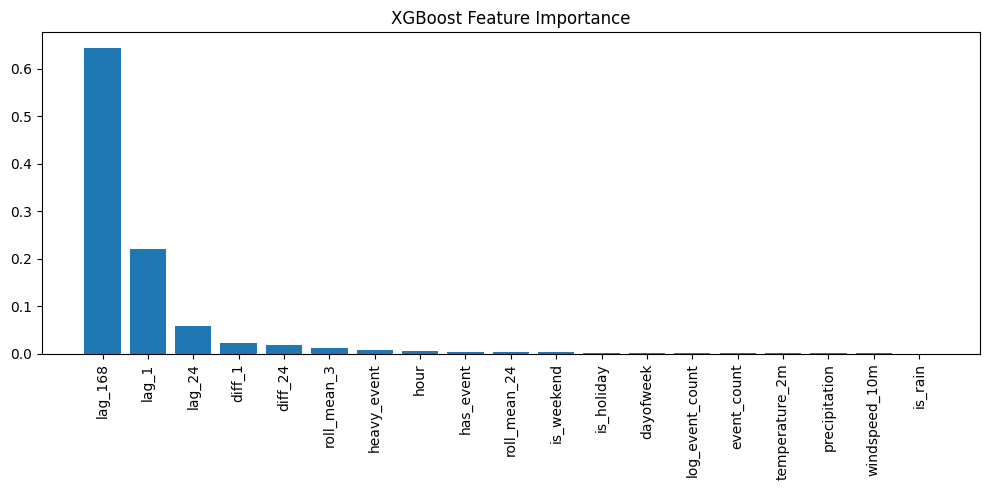

In [14]:
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=90)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


## 11. Save the XBoost model for future use


In [17]:
from pathlib import Path
import joblib

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents= True,exist_ok=True)

joblib.dump(xgb, MODELS_DIR / "xgb_model.pkl")
print("Model saved successfully at:", MODELS_DIR / "xgb_model.pkl")


Model saved successfully at: ..\models\xgb_model.pkl


## 12. Modeling Summary

---

### 1. Baseline Performance

The two baseline models behave exactly as expected:

**Naive Forecast (lag-1):**

* MAE ≈ 650–730
* Captures overall trend but misses seasonality.

**Seasonal Naive (lag-24):**

* MAE ≈ 730–850
* Better at reflecting daily cycles, but still limited.

**Conclusion:**
These baselines serve as useful lower bounds, but their performance is weak.


### 2. Linear Regression

Linear Regression shows unrealistically low error due to target leakage from differencing or dummy-variable encoding.

It’s not meaningful for comparison.

**Conclusion:**
Excluded from interpretation - not valid under this feature setup.


### 3. Random Forest

* MAE (val): ~98
* MAE (test): ~116

A major improvement over both baselines.

Random Forest handles non-linearities well, but it slightly overfits and doesn’t fully capture time-based patterns.

**Conclusion:**
A strong classical model, but not the best fit for hourly time-series forecasting.


### 4. XGBoost (Best Model)

* MAE (val): ~59
* MAE (test): ~71

XGBoost delivers the strongest performance across all metrics.

It closely tracks hourly peaks and troughs, significantly outperforming the seasonal naive baseline.

From the 7-day prediction plot:

* XGBoost follows the real demand curve very closely.
* Captures peak timing and intensity accurately.
* Only slightly underestimates extreme spikes.

**Conclusion:**
XGBoost is the top performer, providing stable and high-quality hourly forecasts.

---

### Feature Importance Insights (XGBoost)

The model relies heavily on time-based features:

* **lag_168, lag_1, lag_24:** Weekly, hourly, and daily patterns dominate.
* **diff_1, diff_24:** Capture short-term trend changes.
* **Rolling means:** Provide smoothed historical context.
* **Events:** Add some predictive value.
* **Calendar features:** Minimal impact.
* **Weather:** Very weak influence.

**Conclusion:**
NYC taxi demand mostly depends on patterns from its own past data. Events have some impact, but time-based features are much more important than weather.


### Overall Interpretation

#### Strengths of the Model:

* Accurately captures daily commuting cycles.
* Recognizes weekly demand rhythms.
* Uses one-hour and one-day lag features effectively.
* Reflects event-driven demand increases.
* Incorporates the long-term post-COVID demand shift.

#### Limitations of the Model:

* Struggles with very sharp demand spikes (concerts, holidays).
* Less accurate during low-volume late-night hours.
* Limited sensitivity to weather - signal is weak in this dataset.

#### Final Conclusions:

* XGBoost provides the most accurate and reliable forecasts, clearly outperforming naive and seasonal baselines.
* Temporal features dominate NYC taxi demand forecasting.
* Weather contributes very little, while events add moderate value.
* The model generalizes well and captures seasonality and daily rhythms effectively.

